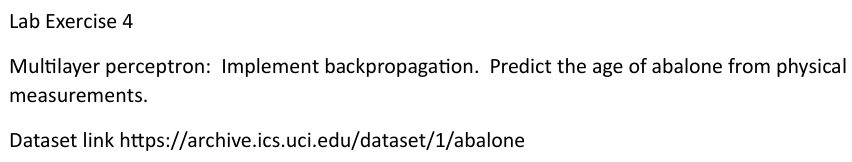

# Imports

In [ ]:
import numpy as np
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# Data Load and Prep

In [ ]:
abalone = fetch_ucirepo(id=1)
def load_abal():
    X_raw = abalone.data.features.values
    y_raw = abalone.data.targets.values.flatten()

    sex_col = X_raw[:, 0]
    num_cols = X_raw[:, 1:].astype(np.float32)
    
    sex_map = {"M": 0, "F": 1, "I": 2}
    sex_idx = np.array([sex_map[s] for s in sex_col])
    sex_one = np.eye(3, dtype=np.float32)[sex_idx]

    X = np.concatenate([sex_one, num_cols], axis=1)
    y = y_raw.astype(np.float32) + 1.5
    y = y.reshape(-1, 1)
    
    return X.astype(np.float32), y.astype(np.float32)

In [3]:
def split_set(X, y, tst_part=0.2, seed=316):
    rng = np.random.default_rng(seed)
    nrow = X.shape[0]
    idx = np.arange(nrow)
    rng.shuffle(idx)

    tst_n = int(nrow * tst_part)
    tst_id = idx[:tst_n]
    trn_id = idx[tst_n:]

    return X[trn_id], X[tst_id], y[trn_id], y[tst_id]


def norm_set(x_tr, x_te):
    x_tr_norm = x_tr.copy()
    x_te_norm = x_te.copy()
    
    mean = x_tr[:, 3:].mean(axis=0, keepdims=True)
    std = x_tr[:, 3:].std(axis=0, keepdims=True) + 1e-8
    
    x_tr_norm[:, 3:] = (x_tr[:, 3:] - mean) / std
    x_te_norm[:, 3:] = (x_te[:, 3:] - mean) / std
    
    return x_tr_norm, x_te_norm, mean, std

# Net with backprop

In [ ]:
class MLP:
    def __init__(self, in_dim, hid_dims, out_dim=1, seed=0):
        rng = np.random.default_rng(seed)
        lay_sz = [in_dim] + list(hid_dims) + [out_dim]

        self.pars = {}
        for i in range(len(lay_sz) - 1):
            fan_in, fan_out = lay_sz[i], lay_sz[i + 1]
            w = rng.normal(
                0,
                np.sqrt(2.0 / fan_in),
                size=(fan_in, fan_out),
            ).astype(np.float32)
            b = np.zeros((1, fan_out), dtype=np.float32)
            self.pars[f"W{i+1}"] = w
            self.pars[f"b{i+1}"] = b

        self.nl = len(lay_sz) - 1

    def fwd(self, x):
        cache = {"A0": x}
        act = x
        for i in range(1, self.nl + 1):
            w = self.pars[f"W{i}"]
            b = self.pars[f"b{i}"]
            z = act @ w + b
            if i != self.nl:
                act = np.maximum(0, z)
            else:
                act = z
            cache[f"Z{i}"] = z
            cache[f"A{i}"] = act
        return act, cache

    def mse(self, y_hat, y_true):
        return np.mean((y_hat - y_true) ** 2)

    def bwd(self, cache, y_true):
        grd = {}
        m = y_true.shape[0]
        a_out = cache[f"A{self.nl}"]

        d_act = (2.0 / m) * (a_out - y_true)

        for i in reversed(range(1, self.nl + 1)):
            a_prev = cache[f"A{i-1}"]
            z = cache[f"Z{i}"]
            w = self.pars[f"W{i}"]

            if i == self.nl:
                d_z = d_act
            else:
                d_z = d_act * (z > 0).astype(np.float32)

            d_w = a_prev.T @ d_z
            d_b = np.sum(d_z, axis=0, keepdims=True)
            d_act = d_z @ w.T

            grd[f"W{i}"] = d_w
            grd[f"b{i}"] = d_b

        return grd

# Optimization Algorithms

In [ ]:
class OptBase:
    def step(self, pars, grd):
        raise NotImplementedError


class SGD(OptBase):
    def __init__(self, lr=1e-3):
        self.lr = lr

    def step(self, pars, grd):
        for k in pars:
            pars[k] -= self.lr * grd[k]


class Mom(OptBase):
    def __init__(self, lr=1e-3, beta=0.9):
        self.lr = lr
        self.bt = beta
        self.vel = {}

    def step(self, pars, grd):
        for k in pars:
            if k not in self.vel:
                self.vel[k] = np.zeros_like(pars[k])
            self.vel[k] = self.bt * self.vel[k] - self.lr * grd[k]
            pars[k] += self.vel[k]


class RMS(OptBase):
    def __init__(self, lr=1e-3, beta=0.9, eps=1e-8):
        self.lr = lr
        self.bt = beta
        self.eps = eps
        self.acc = {}

    def step(self, pars, grd):
        for k in pars:
            if k not in self.acc:
                self.acc[k] = np.zeros_like(pars[k])
            self.acc[k] = self.bt * self.acc[k] + (1 - self.bt) * (grd[k] ** 2)
            pars[k] -= self.lr * grd[k] / (np.sqrt(self.acc[k]) + self.eps)


class Adam(OptBase):
    def __init__(self, lr=1e-3, b1=0.9, b2=0.999, eps=1e-8):
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, pars, grd):
        self.t += 1
        for k in pars:
            if k not in self.m:
                self.m[k] = np.zeros_like(pars[k])
                self.v[k] = np.zeros_like(pars[k])

            self.m[k] = self.b1 * self.m[k] + (1 - self.b1) * grd[k]
            self.v[k] = self.b2 * self.v[k] + (1 - self.b2) * (grd[k] ** 2)

            m_hat = self.m[k] / (1 - self.b1 ** self.t)
            v_hat = self.v[k] / (1 - self.b2 ** self.t)

            pars[k] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

# Train Loop

In [ ]:
def mb_iter(x, y, bsize, seed=0, shuf=True):
    rng = np.random.default_rng(seed)
    nrow = x.shape[0]
    idx = np.arange(nrow)
    if shuf:
        rng.shuffle(idx)
    for pos in range(0, nrow, bsize):
        sl = idx[pos : pos + bsize]
        yield x[sl], y[sl]


def run_fit(
    opt_name="sgd",
    hid_dims=(32, 16),
    lr=1e-3,
    ep_num=100,
    bsize=64,
    seed=316,
):
    def eval():
        y_pred_norm = net.fwd(x_te)[0]
        y_pred = y_pred_norm

        mse = np.mean((y_pred - y_te) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_pred - y_te))
        r2 = 1 - (np.sum((y_te - y_pred) ** 2) / np.sum((y_te - y_te.mean()) ** 2))

        print("\nTest set:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")

    X, y = load_abal()
    x_tr, x_te, y_tr, y_te = split_set(X, y, tst_part=0.2, seed=seed)
    x_tr, x_te, _ , _ = norm_set(x_tr, x_te)

    net = MLP(in_dim=x_tr.shape[1], hid_dims=hid_dims, out_dim=1, seed=seed)

    name = opt_name.lower()
    if name == "sgd":
        opt = SGD(lr=lr)
        tag = "sgd"
    elif name == "moment":
        opt = Mom(lr=lr)
        tag = "mom"
    elif name == "rms":
        opt = RMS(lr=lr)
        tag = "rms"
    elif name == "adam":
        opt = Adam(lr=lr)
        tag = "adm"
    else:
        raise ValueError("bad opt")

    for ep in range(1, ep_num + 1):
        for x_b, y_b in mb_iter(x_tr, y_tr, bsize, seed=seed + ep, shuf=True):
            y_hat, cache = net.fwd(x_b)
            grd = net.bwd(cache, y_b)
            opt.step(net.pars, grd)

        y_tr_hat, _ = net.fwd(x_tr)
        y_te_hat, _ = net.fwd(x_te)
        tr_mse = net.mse(y_tr_hat, y_tr)
        te_mse = net.mse(y_te_hat, y_te)

        if ep % 10 == 0 or ep == 1:
            print(f"{tag} e{ep} {tr_mse:.4f} {te_mse:.4f}")
    
    eval()
    return net

In [ ]:
if __name__ == "__main__":
    for nm, lr in [("sgd", 1e-3), ("moment", 5e-4), ("rms", 1e-3), ("adam", 1e-3)]:
        run_fit(opt_name=nm, lr=lr, ep_num=200, bsize=64, seed=316)

sgd e1 18.8689 23.4034
sgd e10 4.9848 10.9669
sgd e20 4.6343 9.1110
sgd e30 4.4694 8.7684
sgd e40 4.6151 8.3306
sgd e50 4.3397 8.3392
sgd e60 4.2964 8.4021
sgd e70 4.3355 7.9874
sgd e80 4.2886 8.3256
sgd e90 4.2901 8.0669
sgd e100 4.2505 7.9027
sgd e110 4.2625 8.3398
sgd e120 4.3388 7.6013
sgd e130 4.1716 7.8375
sgd e140 4.1622 7.7522
sgd e150 4.3503 8.1629
sgd e160 4.3087 7.8497
sgd e170 4.3301 7.3223
sgd e180 4.1345 7.4100
sgd e190 4.1428 7.3716
sgd e200 4.1073 7.3047

Test set:
MSE: 7.3047
RMSE: 2.7027
MAE: 1.5400
R2: 0.2838
mom e1 6.4936 19.6343
mom e10 4.4135 9.3023
mom e20 4.3266 8.2722
mom e30 4.2064 7.9547
mom e40 4.3236 7.0431
mom e50 4.1155 7.0095
mom e60 4.1019 6.9615
mom e70 4.1145 6.7517
mom e80 4.0720 7.1054
mom e90 4.0471 7.0098
mom e100 3.9948 6.9792
mom e110 3.9863 7.3697
mom e120 3.9639 6.9460
mom e130 3.9878 6.8766
mom e140 3.9367 6.9249
mom e150 4.0498 7.4317
mom e160 3.9331 6.8169
mom e170 3.9770 6.4205
mom e180 3.9716 6.9384
mom e190 3.9564 6.4581
mom e200 3.9222 